# ANN Final Project: Poem Generation

Emma Sheridan and Jessica Petersen

In [46]:
import numpy as np
import pandas as pd 
import random
import sys
import io
from bs4 import BeautifulSoup
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
import requests as rq
import matplotlib.pyplot as plt

### Cleaning the data

In [20]:
pd.options.display.max_colwidth = 1000 # include 1000 characters from each poem 
df = pd.read_csv('PoetryFoundationData.csv') # load dataset from poetryfoundation.com dataset
df = df.dropna() # dropping any entries with no tags 
df.head() # getting top 5 head

,Unnamed: 0,Title,Poem,Poet,Tags
6,6,\r\r\n Invisible Fish\r\r\n,"\r\r\nInvisible fish swim this ghost ocean now described by waves of sand, by water-worn rock. Soon the fish will learn to walk. Then humans will come ashore and paint dreams on the dying stone. Then later, much later, the ocean floor will be punctuated by Chevy trucks, carrying the dreamers’ decendants, who are going to the store.\r\r\n",Joy Harjo,"Living,Time & Brevity,Relationships,Family & Ancestors,Nature,Landscapes & Pastorals,Seas, Rivers, & Streams,Social Commentaries,History & Politics"
7,7,\r\r\n Don’t Bother the Earth Spirit\r\r\n,"\r\r\nDon’t bother the earth spirit who lives here. She is working on a story. It is the oldest story in the world and it is delicate, changing. If she sees you watching she will invite you in for coffee, give you warm bread, and you will be obligated to stay and listen. But this is no ordinary story. You will have to endure earthquakes, lightning, the deaths of all those you love, the most blinding beauty. It’s a story so compelling you may never want to leave; this is how she traps you. See that stone finger over there? That is the only one who ever escaped.\r\r\n",Joy Harjo,"Religion,The Spiritual,Mythology & Folklore,Fairy-tales & Legends"
9,9,"\r\r\n [""Hour in which I consider hydrangea""]\r\r\n","\r\r\nHour in which I consider hydrangea, a salt or sand plant, varietal, the question of varietals, the diet of every mother I know, 5 pounds feels like 20, I have lost … I have lost, yes, a sense of my own possible beauty, grown external, I externalize beauty. Beauty occurs on the surface of plants; the sun darkens the skin of my child, he is so small, he is beautiful (I can see; it is obvious) and everything about him is beautiful. His hand swells from the bite [spread?] of some insect[’s] venom because he is small. He appears to feel nothing. He smashes his skull against the floor. He screams. I hold him in my lap on the kitchen floor in front of an open freezer, pressing a pack of frozen clay against his forehead. He likes the cold. I see; it is so obvious. Hydrangea. When I move, when I walk pushing my child’s stroller (it is both walking and pushing or hauling, sometimes, also, lifting; it is having another body, an adjunct body composed of errand and weight and tenderness a...",Simone White,"Living,Parenthood,The Body,The Mind,Nature,Trees & Flowers"
16,16,\r\r\n scars\r\r\n,\r\r\nmy father’s body is a map\r\r\na record of his journey\r\r\n \r\r\nhe carries a bullet\r\r\nlodged in his left thigh\r\r\nthere is a hollow where it entered\r\r\na protruding bump where it sleeps\r\r\nthe doctors say it will never awaken\r\r\n \r\r\nit is the one souvenir he insists on keeping\r\r\nmother has her own opinionsbố cùa con điên—your father is crazy\r\r\n \r\r\nas a child\r\r\ni wanted a scar just like my father’s\r\r\nbold and appalling a mushroom explosion\r\r\nthat said i too was at war\r\r\ninstead i settled for a grain of rice\r\r\na scar so small look closely there\r\r\nhere between the eyes\r\r\na bit to the right\r\r\nthere on the bridge of my nose\r\r\n \r\r\nfather says i was too young to remember\r\r\nit happened while i was sleeping\r\r\nleaking roof the pounding rain\r\r\ndrop after drop after drop\r\r\n \r\r\n,Truong Tran,"The Body,Family & Ancestors"
17,17,\r\r\n what remains two\r\r\n,\r\r\nit has long been forgotten this practice of the mother\r\r\nweaning a child she crushes the seeds of a green\r\r\nchili rubs it to her nipple what the child feels\r\r\nshe too will share in this act of love\r\r\nmy own mother says it was not meant\r\r\nto be cruel when cruelty she tells me\r\r\nis a child’s lips torn from breast as proof\r\r\nback home the women wear teeth marks\r\r\n \r\r\n,Truong Tran,"Infancy,Parenthood,The Body"


In [40]:
# getting poems that contain the tag Love
poems = df['Poem']
searchfor = ['Love']
lovePoems = poems.loc[df['Tags'].str.contains('|'.join(searchfor))] 
print("Number of Poems: " + str(len(lovePoems)))
lovePoems = lovePoems.to_string()

Number of Poems: 2130


### Preparing Training Data

In [41]:
# MAPPING CHARACTERS: for love poems, Make two dictionaries , one to convert chars to ints, the other to convert ints back to chars

chars = sorted(list(set(lovePoems)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [42]:
# process the dataset:
seqlen = 50
step = seqlen

data_X = []
data_y = []

poemLines = [] 

# creates poem lines 
for i in range(0, len(lovePoems) - seqlen - 1, step):
    poemLines.append(lovePoems[i: i + seqlen + 1])
    
# creating x and y data
data_X = np.zeros((len(poemLines), seqlen, len(chars)), dtype=np.bool)
data_Y = np.zeros((len(poemLines), seqlen, len(chars)), dtype=np.bool)

for i, poemLines in enumerate(poemLines):
    for t, (char_in, char_out) in enumerate(zip(poemLines[:-1], poemLines[1:])):
        data_X[i, t, char_indices[char_in]] = 1
        data_Y[i, t, char_indices[char_out]] = 1

### Model Creation

In [50]:
# create the model
model = Sequential()
model.add(LSTM(80, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01), metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 80)            70080     
_________________________________________________________________
dense_6 (Dense)              (None, 50, 138)           11178     
Total params: 81,258
Trainable params: 81,258
Non-trainable params: 0
_________________________________________________________________


In [52]:
# evaluate the model on validation set and visualize 
history = model.fit(data_X, data_Y, validation_split = .33, batch_size=128, epochs=10)

Train on 28798 samples, validate on 14185 samples
Epoch 1/10
28798/28798 [==============================] - 52s 2ms/step - loss: 1.9350 - categorical_crossentropy: 1.9350 - accuracy: 0.4770 - val_loss: 1.5052 - val_categorical_crossentropy: 1.5052 - val_accuracy: 0.5719
Epoch 2/10
28798/28798 [==============================] - 52s 2ms/step - loss: 1.5037 - categorical_crossentropy: 1.5037 - accuracy: 0.5674 - val_loss: 1.3933 - val_categorical_crossentropy: 1.3933 - val_accuracy: 0.6012
Epoch 3/10
28798/28798 [==============================] - 49s 2ms/step - loss: 1.4157 - categorical_crossentropy: 1.4157 - accuracy: 0.5902 - val_loss: 1.3424 - val_categorical_crossentropy: 1.3424 - val_accuracy: 0.6163
Epoch 4/10
28798/28798 [==============================] - 54s 2ms/step - loss: 1.3723 - categorical_crossentropy: 1.3723 - accuracy: 0.6013 - val_loss: 1.3136 - val_categorical_crossentropy: 1.3136 - val_accuracy: 0.6226
Epoch 5/10
28798/28798 [==============================] - 53s 2ms/

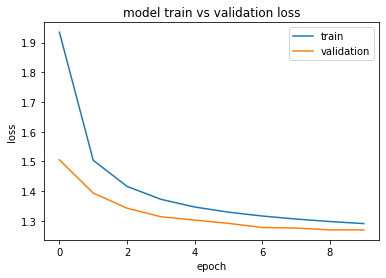

In [53]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Generating Poems

In [54]:
def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)  

In [63]:
def generating_poem(poem_length, start_index, diversity, _):
    start_index = start_index
    diversity = diversity

    generated = ''
    poemLines = lovePoems[start_index: start_index + seqlen]
    generated += poemLines
    print('----- Generating with seed: "' + poemLines + '"')
    sys.stdout.write(generated)

    for i in range(poem_length):
        x_pred = np.zeros((1, seqlen, len(chars)))
        for t, char in enumerate(poemLines):
            x_pred[0, t, char_indices[char]] = 1.
            
        preds = model.predict(x_pred, verbose=0)
        next_index = sample(preds[0, -1], diversity)
        next_char = indices_char[next_index]

        poemLines = poemLines[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [90]:
generating_poem(500, 1500, .5, _)

----- Generating with seed: "r\r\n \r\r\nRoy and Glen\r\r\nlost themselves\r\r\"
r\r\n \r\r\nRoy and Glen\r\r\nlost themselves\r\r\nis the world the prides or story in the starting the discapive to the stranged start us the wind. The down the stucky strange and the last the sky   \r\r\neach an all the spon and carry me heart and set, and the bright have so sand for the stranged of the stranger. I see we between my leaves stranged the skies in the annt, sweet of at the same shade to heart, and the can don’t grape in not so self\r\r\n                                                                                             


And it won’t be multiple choiced in the sky love and made the back between the forest and the from the black and sky feet promised which her desire. I could come before the point to the collation.

I am a dear the shadows and which stare of the father, the cheek and boxasted seeman that the confecting the can sweating while I moved me can don’t know you want to still watch the stater and we can see a poem who deep of bene to the didn’t were been on the breaks dark in the tongue and blood from the color in the morning on t


Roy and Glen
lost themselves
is the world the prides or story in the starting the discapive to the stranged start us the wind. The down the stucky strange and the last the sky
each an all the spon and carry me heart and set, and the bright have so sand for the stranged of the stranger. I see we between my leaves stranged the skies in the annt, sweet of at the same shade to heart, and the can don’t grape in not so self


In [91]:
generating_poem(500, 2487, .5, _)

----- Generating with seed: "r\r\nThe woman carried the bucket\r\r\nand the man"
r\r\nThe woman carried the bucket\r\r\nand the man with sing are fingers the soft in this do, and of the conficial from the strangering to my slight which the sky stead between the body of a sation under there is the spring became and prices air strange of me to mouth have at his blossoms the sands in the trangs of the stared a paration in the man spring of carvant\r\r\n                                                                                                                                                                                 


The woman carried the bucket
and the man with sing are fingers the soft in this do, and of the conficial from the strangering to my slight which the sky stead between the body of a sation under there is the spring became and prices air strange of me to mouth have at his blossoms the sands in the trangs of the stared a paration in the man spring of carvant